# Dynamic Mode Decomposition (DMD) on large ERA5 slice

This notebook shows how to apply Optimized DMD (OptDMD) and Bagging Optimized DMD (BOPDMD) to a large slice of the [ERA5 dataset](https://weatherbench2.readthedocs.io/en/latest/data-guide.html#era5) using the SVDROM package directly on a laptop. OptDMD is a flavor of DMD that is designed to work with noisy datasets where the snapshots may have been collected at unevenly spaced sample times. It is the state-of-the-art, generally recommended all-purpose method for real-world noisy data. OptDMD can be further enhanced by using Bootstrap Aggregation or bagging (BOPDMD), which allows to reduce model variance/over-fitting, stabilize the DMD fit to the data, and produce forecasts with uncertainty quantification.

OptDMD and BOPDMD are enabled via the `OptDMD` class of SVDROM. To minimize computational cost, `OptDMD` is designed to work on the SVD projection of the data. The SVD pre-processing step allows to massively reduce the size of the input dataset, while retaining most of the original information. Additionally, performing SVD and retaining only the large singular values and their associated singular vectors allows to de-noise the data prior to the DMD fit.

Useful references:

* [Bagging, optimized dynamic mode decomposition (BOP-DMD) for robust, stable forecasting with spatial and temporal uncertainty-quantification](https://arxiv.org/abs/2107.10878)
* [Variable Projection Methods for an Optimized Dynamic Mode Decomposition](https://arxiv.org/abs/1704.02343)
* [PyDMD: A Python package for robust dynamic mode decomposition](https://arxiv.org/abs/2402.07463)

In [1]:
import pickle
from datetime import timedelta

import cartopy.crs as ccrs
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from svdrom.dask_utils import init_dask
from svdrom.dmd import OptDMD
from svdrom.io import open_dataarray
from svdrom.preprocessing import StandardScaler, variable_spatial_stack
from svdrom.svd import TruncatedSVD

## 1. Compute the SVD

Initialize a local Dask cluster with multi-threading and dashboard support. Because the SVD calculation is dominated by NumPy operations that release the Python GIL, we can achieve true parallelism using multiple threads in a single process. You can monitor the cluster at http://localhost:8787/status.

In [4]:
client = init_dask(dashboard=True)

2025-10-17 14:12 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
[dask_utils.py:48 -            init_dask() ] Started a local multi-thread Dask cluster with dashboard support.
2025-10-17 14:12 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status
[dask_utils.py:51 -            init_dask() ] Dashboard link: http://localhost:8787/status


Load the ERA5 slice as a Xarray DataArray.

In [2]:
era5_path = "data/era5_slice.zarr"
X = open_dataarray(era5_path)

2025-10-21 10:02 - I/O - INFO - Opening Xarray.DataArray from data/era5_slice.zarr.
[io.py:68 -       open_dataarray() ] Opening Xarray.DataArray from data/era5_slice.zarr.


The DataArray contains approximately 35 GB of atmospheric temperature measurements at a pressure level of 500hPa. It has approximately 9000 temporal snapshots between Jan 2016 and Feb 2020, with a time delta of 4 hours between snapshots. The latitude and longitude spatial resolution is 721 and 1440 points, respectively (0.25 deg grid). 

In [3]:
X

<xarray.DataArray 'temperature' (time: 9126, latitude: 721, longitude: 1440)> Size: 38GB
dask.array<open_dataset-temperature, shape=(9126, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 73kB 2016-01-01 ... 2020-02-29T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B ...
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

We will use the data between 1 Jan 2016 and 31 Dec 2019 to fit the DMD model, and we will save the Jan and Feb 2020 data to evaluate the accuracy of the forecast.

In [38]:
X = X.sel(time=slice("2016-01-01", "2019-12-31"))
X

<xarray.DataArray 'temperature' (time: 8766, latitude: 721, longitude: 1440)> Size: 36GB
dask.array<getitem, shape=(8766, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B ...
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

Firstly, calculate and remove the time average from the data, as we only want to model the temporal fluctuations about the mean with DMD. We can use the `StandardScaler` class to do so.

In [5]:
scaler = StandardScaler()
X = scaler(X)

2025-10-10 14:39 - Preprocessing - INFO - Computing mean along dimension time...
[preprocessing.py:124 -             __call__() ] Computing mean along dimension time...
2025-10-10 14:39 - Preprocessing - INFO - Finished computing mean.
[preprocessing.py:127 -             __call__() ] Finished computing mean.


In [6]:
X

<xarray.DataArray 'temperature' (time: 8766, latitude: 721, longitude: 1440)> Size: 36GB
dask.array<sub, shape=(8766, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

We then want to stack the latitude and longitude dimensions along a single spatial dimension. We want to get a tall-and-skinny matrix of dimensions `space x time`, so we also need to transpose the matrix.

In [7]:
X = variable_spatial_stack(X, dims=("latitude", "longitude"))

2025-10-10 14:40 - Preprocessing - INFO - Performing spatial stacking.
[preprocessing.py:55 - variable_spatial_stack() ] Performing spatial stacking.


In [8]:
X

<xarray.DataArray 'temperature' (time: 8766, samples: 1038240)> Size: 36GB
dask.array<reshape, shape=(8766, 1038240), dtype=float32, chunksize=(32, 1038240), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * samples    (samples) object 8MB MultiIndex
    level      int64 8B 500
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [ ]:
X = X.T  # transpose the matrix to obtain dimensions space (or samples) x time

In [10]:
X

<xarray.DataArray 'temperature' (samples: 1038240, time: 8766)> Size: 36GB
dask.array<transpose, shape=(1038240, 8766), dtype=float32, chunksize=(1038240, 32), chunktype=numpy.ndarray>
Coordinates:
  * samples    (samples) object 8MB MultiIndex
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
    level      int64 8B 500
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Once we have pre-processed the matrix, we can perform a truncated SVD using the randomized SVD algorithm. We compute 40 components, and we request to rechunk the array to obtain a matrix chunked along the row dimension only as this increases accuracy (see `svd_demo_1.ipynb` and `svd_demo_2.ipynb` for an overview of SVD).

In [11]:
rand_svd = TruncatedSVD(
    n_components=40,
    algorithm="randomized",
    rechunk=True,
    compute_var_ratio=True,
)

Perform the fit, increasing the number of power iterations and oversamples to improve the accuracy of the randomized SVD algorithm. Note that the array is 35 GB in size, so this will take a few minutes. You can monitor progress on the cluster dashboard.

In [12]:
rand_svd.fit(X, n_power_iter=2, n_oversamples=15)

2025-10-10 14:41 - SVD - INFO - Will use randomized algorithm.
[svd.py:246 -                  fit() ] Will use randomized algorithm.
2025-10-10 14:41 - SVD - INFO - The input array is considered tall-and-skinny. Will rechunk the array before fitting the SVD. This will add some overhead.
[svd.py:142 -       _rechunk_array() ] The input array is considered tall-and-skinny. Will rechunk the array before fitting the SVD. This will add some overhead.
2025-10-10 14:41 - SVD - INFO - Computing SVD results...
[svd.py:267 -                  fit() ] Computing SVD results...
2025-10-10 14:45 - SVD - INFO - Done.
[svd.py:270 -                  fit() ] Done.


Plot the cumulative sum of explained variance. We see that with 40 components we retain over 80% of the original variance, with the first component alone explaining over 55%.

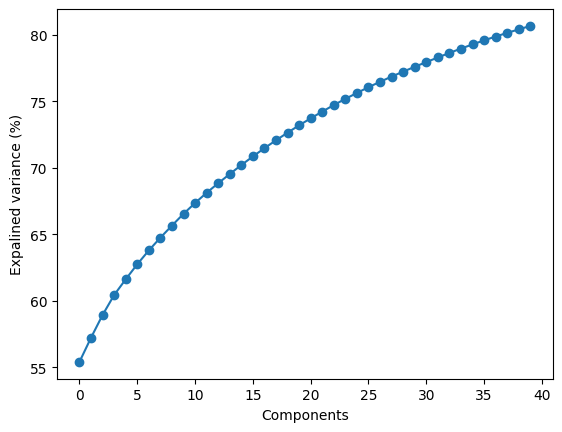

In [13]:
plt.plot(np.cumsum(rand_svd.explained_var_ratio)*100, "o-")
plt.xlabel("Components")
plt.ylabel("Expalined variance (%)")
plt.show()

If we plot the first right singular vector, which contains temporal information, we see that the first component clearly represents the winter/summer temperature fluctuation.

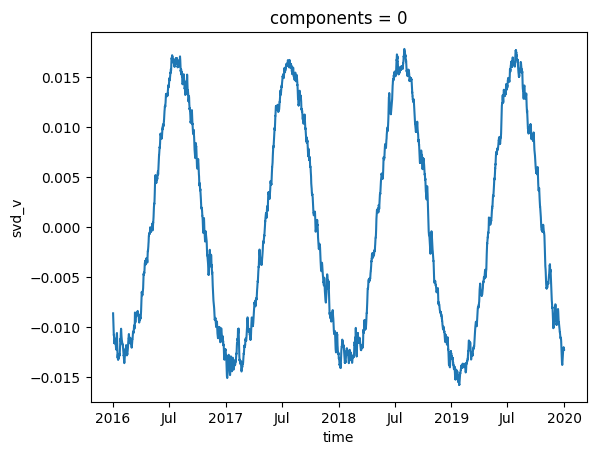

In [14]:
rand_svd.v[0, :].plot()
plt.show()

We can now close the Dask cluster, and save the computed `TruncatedSVD` and `StandardScaler` instances to pickle files on disk.

In [21]:
client.close()

[worker.py:1561 -                close() ] Stopping worker at inproc://10.100.0.2/79368/4. Reason: worker-close
[worker.py:1901 -        plugin_remove() ] Removing Worker plugin shuffle


In [20]:
with open("data/results/rand_svd_results.pkl", "wb") as f:
    pickle.dump(rand_svd, f)

with open("data/results/standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## 2. Compute the DMD

OptDMD and BOPDMD are implemented via the `OptDMD` class of SVDROM. As explained above, `OptDMD` operates on the results of the SVD, which are small compared to the original matrix `X`. If you don't want to perform bootstrap aggregation/bagging (i.e. you just want vanilla OptDMD), this is a relatively straight forward calculation that won't take more than a few minutes on a single core even for very large matrices. However, if you want to perform bagging, you typically want to compute 50 to 100 bags to obtain reliable ensemble statistics. That means that the optimized DMD fit needs to be computed 50 to 100 times on different random data samples, which can easily take hours for large matrices on a single core. In this situation, it's best to parallelize the bagging computation.

Here we will compute three DMD models:

1. One with 30 DMD modes and no bagging.
2. One With 40 DMD modes and no bagging
3. One with 40 DMD modes with bagging. 40 modes is a relatively large number that could overfit the training data by trying to model noise. In this situation, bagging might help.

### Parallelized bagging

Python's GIL allows only one thread to execute at a time. However, because we are dealing with CPU-bound code with NumPy-heavy computations, we can take advantage of the fact that many NumPy operations release the GIL, enabling true parallelization even on a single process. Running in a single process also amortizes the overhead of serializing/deserializing data for inter-process communication. For this type of workload, it is therefore recommended to use a Dask distributed cluster with a single multi-threaded worker. The worker runs on a separate process to the main Python process from where the tasks are submitted, so it has its own GIL that does not interfere with the main process. NumPy operations on the worker can release the worker's GIL, allowing parallelization. Alternatively, the code could also be executed across multiple processes/workers, but in that case we would have the extra overhead of inter-process communication, which might make things a bit slower.

Start a Dask distributed cluster with a single multi-threaded worker.

In [4]:
client = init_dask(dashboard=True)  # single multi-threaded worker
# alternatively you could use multiple workers, with the penalty of inter-process communication
# client = init_dask(dashboard=True, processes=True)  # multiple multi-threaded workers

2025-10-17 13:32 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
[dask_utils.py:48 -            init_dask() ] Started a local multi-thread Dask cluster with dashboard support.
2025-10-17 13:32 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status
[dask_utils.py:51 -            init_dask() ] Dashboard link: http://localhost:8787/status


If necessary, load the SVD results from disk, as we need them to compute the DMD.

In [5]:
with open("data/results/rand_svd_results.pkl", "rb") as f:
    rand_svd = pickle.load(f)

Now create the `OptDMD` instances, two with no bags and a third one with 50 bags/trials, with each bag containing 90% of the temporal snapshots (randomly sampled while maintaining time order). Request that the bagging is performed in parallel. Additionally, specify the time units of the data as hours. Doing so will return all temporal results in those time units.

In [ ]:
# 30 modes, without bagging
optdmd_30 = OptDMD(
    n_modes=30,
    time_units="h",
)

In [ ]:
# 40 modes, without bagging
optdmd_40 = OptDMD(
    n_modes=40,
    time_units="h",
)

In [ ]:
# 40 modes, with bagging
bopdmd_40 = OptDMD(
    n_modes=40,
    time_units="h",
    num_trials=50,  # requesting bagging with 50 trials
    trial_size=0.9,  # sampling fraction per bag
    parallel_bagging=True,
)

Now call the `fit` method, passing the left singular vectors (`U`), the singular values (`s`) and the right singular vectors (`V`) from the SVD computation. Since we have a Dask cluster running and we have set `parallel_bagging=True`, the bagging for the BOPDMD model (`bopdmd_40`) will be performed in parallel using all available CPU cores. You can monitor progress on http://localhost:8787/status. In my case, this took around 18 min using the 10 cores of my Mac M1.

In [8]:
%%time
# no bagging, runs sequentially
optdmd_30.fit(
    rand_svd.u,
    rand_svd.s,
    rand_svd.v,
)

2025-10-17 14:15 - DMD - INFO - Computing the DMD fit...
[dmd.py:394 -                  fit() ] Computing the DMD fit...
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:996: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)
2025-10-17 14:16 - DMD - INFO - Done.
[dmd.py:410 -                  fit() ] Done.


CPU times: user 38.4 s, sys: 11.6 s, total: 50 s
Wall time: 38.4 s


In [6]:
%%time
# no bagging, runs sequentially
optdmd_40.fit(
    rand_svd.u,
    rand_svd.s,
    rand_svd.v,
)

2025-10-18 17:25 - DMD - INFO - Computing the DMD fit...
[dmd.py:394 -                  fit() ] Computing the DMD fit...
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:996: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)
2025-10-18 17:26 - DMD - INFO - Done.
[dmd.py:410 -                  fit() ] Done.


CPU times: user 1min 12s, sys: 24.7 s, total: 1min 37s
Wall time: 1min 12s


In [ ]:
%%time
# with bagging, runs in parallel - monitor on http://localhost:8787/status
bopdmd_40.fit(
    rand_svd.u,
    rand_svd.s,
    rand_svd.v,
)

2025-10-17 14:17 - DMD - INFO - Computing the DMD fit...
[dmd.py:394 -                  fit() ] Computing the DMD fit...
2025-10-17 14:17 - DMD - INFO - Bagging will be performed in parallel.
[dmd.py:398 -                  fit() ] Bagging will be performed in parallel.
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:996: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 159.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more inf

Number of converged bags: 0 out of 50. Consider loosening the tol requirements of the variable projection routine.


2025-10-17 14:34 - DMD - INFO - Done.
[dmd.py:410 -                  fit() ] Done.


CPU times: user 1h 30min 23s, sys: 20min 29s, total: 1h 50min 52s
Wall time: 17min 45s


Save the DMD results to pickle files on disk, and close the Dask cluster.

In [ ]:
with open("data/results/optdmd_30_modes.pkl", "wb") as f:
    pickle.dump(optdmd_30, f)

In [7]:
with open("data/results/optdmd_40_modes.pkl", "wb") as f:
    pickle.dump(optdmd_40, f)

In [ ]:
with open("data/results/bopdmd_40_modes.pkl", "wb") as f:
    pickle.dump(bopdmd_40, f)

In [12]:
client.close()

## 3. Plot the BOPDMD results

In this section we will analyze the BOPDMD (i.e. optimized DMD with bagging) results computed above. If necessary, load them from disk.

In [4]:
with open("data/results/bopdmd_40_modes.pkl", "rb") as f:
    bopdmd_40 = pickle.load(f)

The DMD modes and their standard deviation are defined on the same spatial grid as the matrix of left singular values (`U`). Note that SVDROM conveniently outputs results as Xarray DataArrays, inheriting all metadata from the inputs, which makes the results very easy to plot. We need to unstack the spatial dimension to return to the original latitude/longitude grid.

In [5]:
modes = bopdmd_40.modes.unstack()
modes_std = bopdmd_40.modes_std.unstack()

It's also handy to sort the modes in descending order of mode amplitude. The amplitude can be seen as the weight of a mode in the overall reconstruction of the fitted data. 

In [6]:
mode_order = np.argsort(-np.abs(bopdmd_40.amplitudes))
print(mode_order)

[21 18  9 30 16 23 19 20 24 15 37  2 12 27 13 26 10 29 14 25 28 11 32  7
  5 34 38  1 35  4  0 39 36  3 33  6 31  8 17 22]


In [7]:
modes

<xarray.DataArray 'dmd_modes' (components: 40, latitude: 721, longitude: 1440)> Size: 664MB
array([[[ 3.80711657e-04-7.95858112e-04j,
          3.80711687e-04-7.95858163e-04j,
          3.80711682e-04-7.95858108e-04j, ...,
          3.80711695e-04-7.95858150e-04j,
          3.80711695e-04-7.95858150e-04j,
          3.80711695e-04-7.95858150e-04j],
        [ 3.70227577e-04-5.60022829e-04j,
          2.88455819e-04-6.18191796e-04j,
          1.97202747e-04-5.76528735e-04j, ...,
          3.31227850e-04-7.66441089e-04j,
          3.50990794e-04-6.99483352e-04j,
          2.46969164e-04-6.52533299e-04j],
        [ 2.78966042e-04-6.67972795e-04j,
          3.41977916e-04-6.86839790e-04j,
          3.52874515e-04-8.08712799e-04j, ...,
          2.78637495e-04-6.41379047e-04j,
          2.47296059e-04-6.88596474e-04j,
          1.79104353e-04-7.40424005e-04j],
        ...,
        [ 6.04141006e-05-5.86230528e-05j,
...
          1.79104353e-04+7.40424005e-04j],
        ...,
        [ 6.04141006e-05+5.86230528e-05j,
          6.56713612e-05+9.53184642e-05j,
          1.70810505e-05+7.77673265e-05j, ...,
          1.48934374e-05+1.00831364e-04j,
          4.87073082e-05+7.65489925e-05j,
          3.90204706e-05+1.73990613e-04j],
        [-2.95279017e-05+7.19755030e-05j,
          4.17773929e-05+7.75090585e-05j,
          2.95660160e-05+9.75493463e-05j, ...,
          1.45510789e-07+4.97632687e-05j,
          5.29207087e-05+1.15174566e-04j,
          2.39014684e-05+1.37712782e-04j],
        [ 4.96772133e-05+1.49111214e-04j,
          4.96772133e-05+1.49111214e-04j,
          4.96772133e-05+1.49111214e-04j, ...,
          4.76456682e-05+1.48467059e-04j,
          4.76456682e-05+1.48467059e-04j,
          4.76456682e-05+1.48467059e-04j]]], shape=(40, 721, 1440))
Coordinates:
  * components  (components) int64 320B 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * latitude    (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level       int64 8B 500

The code below plots the first DMD mode on a world map using the Cartopy library. As can be seen, it clearly represents the winter/summer temperature fluctuation, with a clear split between the Northern and Southern hemispheres. Note that the DMD modes are obtained by averaging results across all bags used in bootstrap aggregation, providing more stable results that should overfit the training data less. A plot of a DMD mode can be understood as a spatial pattern associated with a particular temporal oscillation. It has a similar interpretation to a POD mode, with the added constraint of being associated with a unique temporal oscillation frequency: blue regions tend to be positively correlated with other blue regions, and negatively correlated with red regions. For the first DMD mode, when it is summer in the Northern hemisphere, it is winter in the Southern hemisphere (i.e. there is a negative correlation between them), and the frequency of this particular oscillation is one year.

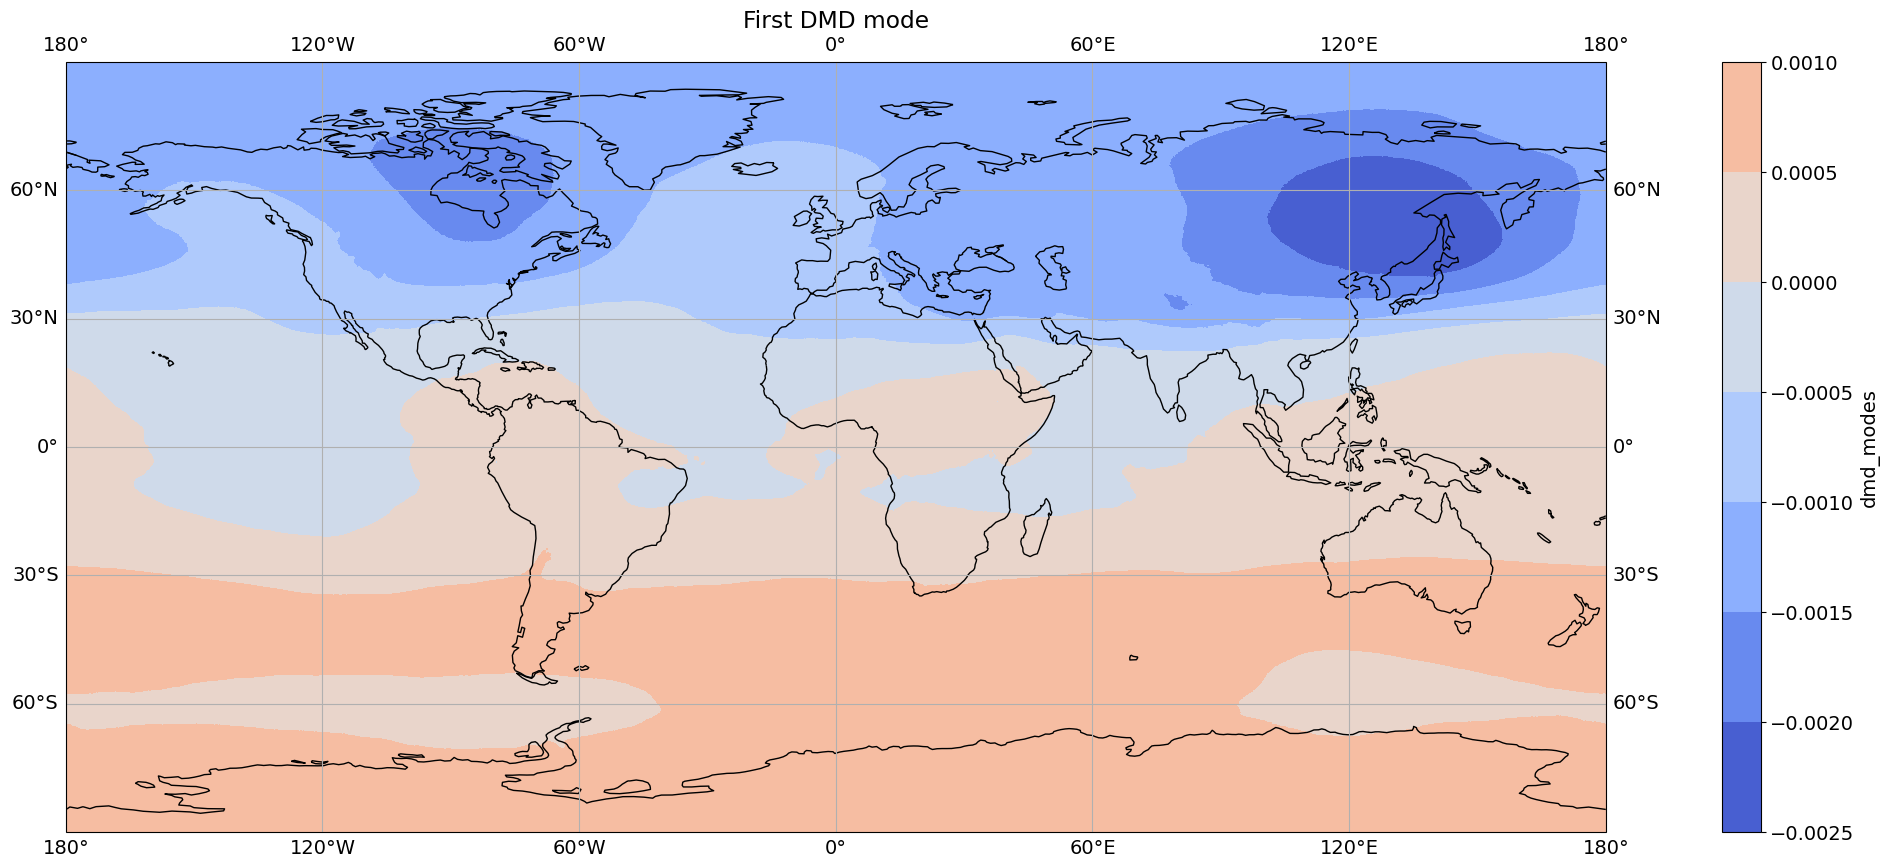

In [8]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# plot the real part of the DMD mode with highest amplitude
modes[mode_order[0], :, :].real.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)

plt.title("First DMD mode")
plt.show()

We can also plot the standard deviation of the first mode across all bootstrap aggregation trials. This gives an indication of the spatial uncertainty associated with the first DMD mode. The plot can be understood as a map of the spatial patterns where DMD is most uncertain in its ability to provide an accurate reconstruction. As shown, the highest spatial uncertainty of the first mode occurs close to the Northern and Southern poles, but the standard deviation is two orders of magnitude smaller than the mean shown above, so we can conclude that there is relatively little variability across our bagging trials for this particular mode.

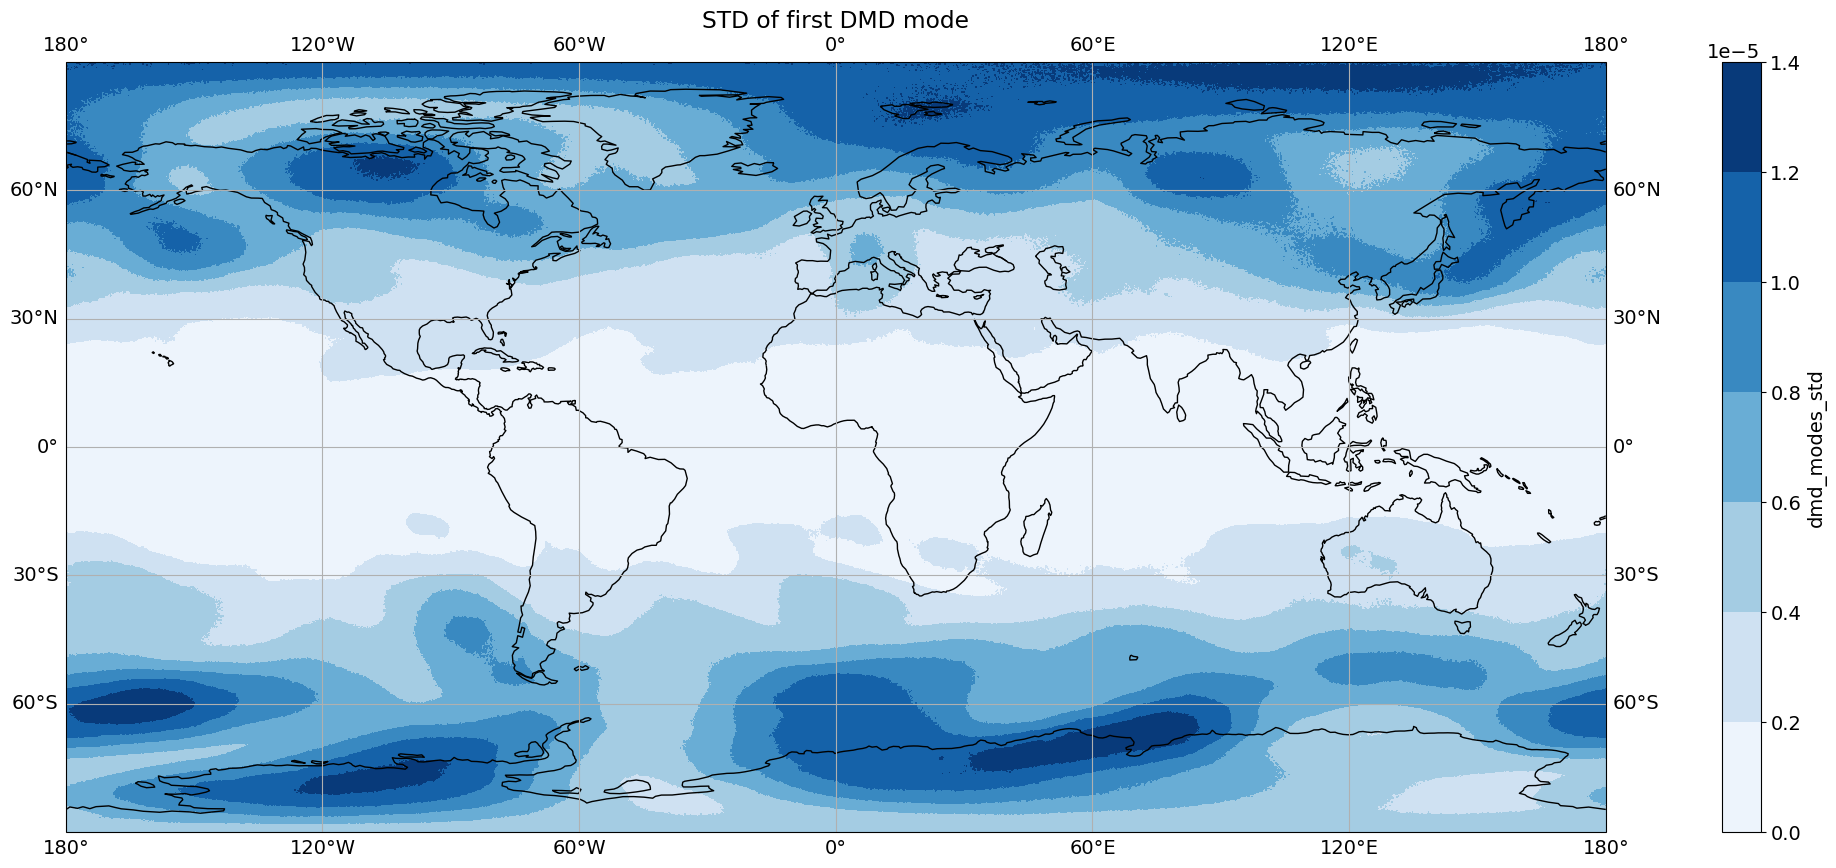

In [9]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

modes_std[mode_order[0], :, :].real.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='Blues',
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)

plt.title("STD of first DMD mode")
plt.show()

We can also plot the temporal evolution of the first DMD mode using the `dynamics` attribute, which clearly shows an annual oscillation frequency.

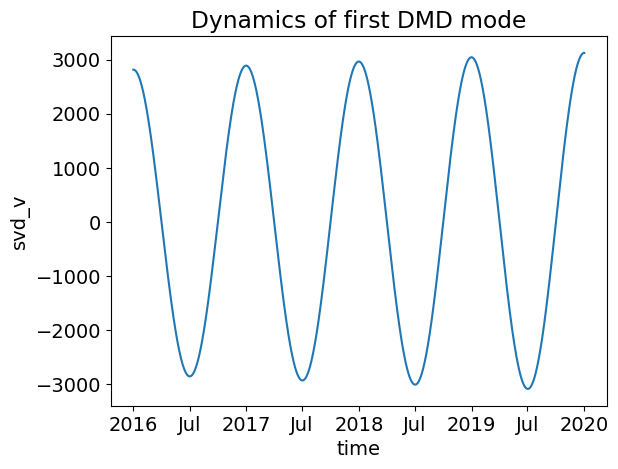

In [10]:
# plot the real part of the temporal evolution of the first DMD mode
bopdmd_40.dynamics[mode_order[0], :].real.plot()
plt.title("Dynamics of first DMD mode")
plt.show()

We can also confirm the oscillation frequency of the first DMD mode by looking at the imaginary part of its eigenvalue. The eigenvalues can be accessed via the `eigs` attribute.

In [11]:
hours_per_day = 24
oscillation_period = 2 * np.pi / abs(bopdmd_40.eigs[mode_order[0]].imag) / hours_per_day
print(f"Oscillation period of 1st DMD mode: {oscillation_period:.2f} days")

Oscillation period of 1st DMD mode: 365.08 days


## 4. Evaluate the DMD models

This section will evaluate the quality of both the OptDMD (i.e. no bagging) and BOPDMD (i.e. with bagging) models by computing the RMSE score of the reconstruction of the last two months of training data (i.e. Nov and Dec 2019), and the forecast of the first 6 weeks of 2020.

If you need to, load the computed `OptDMD` instances from disk.

In [12]:
with open("data/results/optdmd_30_modes.pkl", "rb") as f:
    optdmd_30 = pickle.load(f)

In [13]:
with open("data/results/optdmd_40_modes.pkl", "rb") as f:
    optdmd_40 = pickle.load(f)

In [14]:
with open("data/results/bopdmd_40_modes.pkl", "rb") as f:
    bopdmd_40 = pickle.load(f)

### 4.1 Compute the reconstruction of Nov and Dec 2019

First, we will compute the reconstruction of the last two months of training data. For this purpose we can use the `reconstruct` method, passing a slice specifying the time range we want to reconstruct. When bagging has been used, `reconstruct` returns two arrays: the mean reconstruction and the reconstruction variance, which are computed using a Monte-Carlo simulation with the computed BOPDMD statistics. The reconstruction variance provides a measure of uncertainty. By default, if the estimated array size is greater than 1 GB, SVDROM will compute the reconstruction with Dask. Note that this computation is lazy - it doesn't happen until we trigger it.

In [15]:
# reconstruct the training data between 1st Nov 2019 and 31st Dec 2019
recon_optdmd_30 = optdmd_30.reconstruct(t=slice("2019-11-01", "2019-12-31"))  # this is lazy

2025-10-21 10:47 - DMD - INFO - Estimated reconstruction size is 6079933.440 KB.
[dmd.py:734 -          reconstruct() ] Estimated reconstruction size is 6079933.440 KB.
2025-10-21 10:47 - DMD - INFO - Will use Dask to compute the reconstruction.
[dmd.py:737 -          reconstruct() ] Will use Dask to compute the reconstruction.
2025-10-21 10:47 - DMD - INFO - Computing the DMD reconstruction...
[dmd.py:743 -          reconstruct() ] Computing the DMD reconstruction...
2025-10-21 10:47 - DMD - INFO - Done.
[dmd.py:750 -          reconstruct() ] Done.


In [16]:
# reconstruct the training data between 1st Nov 2019 and 31st Dec 2019
recon_optdmd_40 = optdmd_40.reconstruct(t=slice("2019-11-01", "2019-12-31"))  # this is lazy

2025-10-21 10:48 - DMD - INFO - Estimated reconstruction size is 6079933.440 KB.
[dmd.py:734 -          reconstruct() ] Estimated reconstruction size is 6079933.440 KB.
2025-10-21 10:48 - DMD - INFO - Will use Dask to compute the reconstruction.
[dmd.py:737 -          reconstruct() ] Will use Dask to compute the reconstruction.
2025-10-21 10:48 - DMD - INFO - Computing the DMD reconstruction...
[dmd.py:743 -          reconstruct() ] Computing the DMD reconstruction...
2025-10-21 10:48 - DMD - INFO - Done.
[dmd.py:750 -          reconstruct() ] Done.


In [17]:
# reconstruct the training data between 1st Nov 2019 and 31st Dec 2019
recon_bopdmd_40, recon_bopdmd_40_var = bopdmd_40.reconstruct(t=slice("2019-11-01", "2019-12-31"))  # this is lazy

2025-10-21 10:49 - DMD - INFO - Estimated reconstruction size is 6079933.440 KB.
[dmd.py:734 -          reconstruct() ] Estimated reconstruction size is 6079933.440 KB.
2025-10-21 10:49 - DMD - INFO - Will use Dask to compute the reconstruction.
[dmd.py:737 -          reconstruct() ] Will use Dask to compute the reconstruction.
2025-10-21 10:49 - DMD - INFO - Computing the DMD reconstruction...
[dmd.py:743 -          reconstruct() ] Computing the DMD reconstruction...
2025-10-21 10:49 - DMD - INFO - Done.
[dmd.py:750 -          reconstruct() ] Done.


As shown below, the reconstruction mean and variance are Dask-backed Xarray DataArrays. SVDROM will chunk the array along the time dimension only, attempting to achieve chunks of size approximately equal to the one specified in the Dask config (128 MiB by default). Leaving the spatial dimension unchunked facilitates unstacking it, if it's necessary to do so. 

In [18]:
recon_optdmd_40

<xarray.DataArray 'dmd_prediction' (samples: 1038240, time: 366)> Size: 6GB
dask.array<sum-aggregate, shape=(1038240, 366), dtype=complex128, chunksize=(1038240, 8), chunktype=numpy.ndarray>
Coordinates:
  * samples    (samples) object 8MB MultiIndex
  * time       (time) datetime64[ns] 3kB 2019-11-01 ... 2019-12-31T20:00:00
    level      int64 8B 500
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

We need to unstack the spatial dimension to return to the original lat/lon grid.

In [19]:
recon_optdmd_30 = recon_optdmd_30.unstack()
recon_optdmd_40 = recon_optdmd_40.unstack()
recon_bopdmd_40 = recon_bopdmd_40.unstack()
recon_bopdmd_40_var = recon_bopdmd_40_var.unstack()

Additionally, because we only modelled the fluctuations over the time average with DMD, we now want to add back the time average to our mean reconstruction. To do so we need the `StandardScaler` instance we computed earlier. Load it from disk if necessary.

In [20]:
with open("data/results/standard_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [21]:
# add the time average to the mean DMD reconstruction, keeping
# the metadata of the original mean reconstruction array
recon_optdmd_30 = recon_optdmd_30.copy(data=recon_optdmd_30+scaler.mean)
recon_optdmd_40 = recon_optdmd_40.copy(data=recon_optdmd_40+scaler.mean)
recon_bopdmd_40 = recon_bopdmd_40.copy(data=recon_bopdmd_40+scaler.mean)

All operations so far have been lazy - we have just built a Dask task graph that we now need to compute. We can either compute the reconstruction and keep it in memory, or save to disk chunk by chunk as we compute the chunks. In this case the arrays are not massive, so we could keep them in memory. Nevertheless, here we will save them to disk as we compute them as we will need to save them regardless, and it shows how you would deal with large arrays that may overwhelm your RAM. We will also start a multi-threaded Dask cluster with dashboard support to monitor the computations.

In [ ]:
client = init_dask(dashboard=True)

2025-10-21 11:06 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
[dask_utils.py:48 -            init_dask() ] Started a local multi-thread Dask cluster with dashboard support.
2025-10-21 11:06 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status
[dask_utils.py:51 -            init_dask() ] Dashboard link: http://localhost:8787/status


/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in sqrt
  return self.func(*new_argspec)
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in sqrt
  return self.func(*new_argspec)
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in sqrt
  return self.func(*new_argspec)


In [23]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
recon_optdmd_30.to_zarr(
    "data/results/recon_optdmd_30_modes_NovDec2019.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 487.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [24]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
recon_optdmd_40.to_zarr(
    "data/results/recon_optdmd_40_modes_NovDec2019.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 645.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [25]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
recon_bopdmd_40.to_zarr(
    "data/results/recon_bopdmd_40_modes_NovDec2019.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 658.56 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [26]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
recon_bopdmd_40_var.to_zarr(
    "data/results/recon_var_bopdmd_40_modes_NovDec2019.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 654.60 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### 4.2 Compute the forecast of the first six weeks of 2020

We can now follow a similar procedure as above to compute the forecast. We need to use the `forecast()` method, which works very similarly to `reconstruct()`, but which projects the BOPDMD results onto a future time vector, i.e. it predicts unseen data. Similarly to `reconstruct()`, `forecast()` returns two arrays when bootstrap aggregation has been employed, corresponding to the mean and the variance of a Monte Carlo simulation computed using the BOPDMD statistics. The variance provides an uncertainty quantification for the forecast.

The inputs to the `forecast()` methods are slightly different to those of `reconstruct()`. Instead of providing a time slice, we provide a time span over which we want to produce the forecast, starting from the last time step in the training data. Below we specify 45 days, which covers all of January 2020 and the first half of Feb 2020. `dt` is the time step for the forecast. `dt=None` (the default) means that the forecast should use the same time step as the training data (4 hrs in this case).

In [ ]:
forecast_optdmd_30 = optdmd_30.forecast(forecast_span="45 D", dt=None)  # this computation is lazy

2025-10-20 13:01 - DMD - INFO - Estimated forecast size is 4485196.800 KB.
[dmd.py:622 -             forecast() ] Estimated forecast size is 4485196.800 KB.
2025-10-20 13:01 - DMD - INFO - Will use Dask to compute the forecast.
[dmd.py:625 -             forecast() ] Will use Dask to compute the forecast.
2025-10-20 13:01 - DMD - INFO - Computing the DMD forecast...
[dmd.py:631 -             forecast() ] Computing the DMD forecast...
2025-10-20 13:01 - DMD - INFO - Done.
[dmd.py:638 -             forecast() ] Done.


In [18]:
forecast_optdmd_40 = optdmd_40.forecast(forecast_span="45 D")  # this computation is lazy

2025-10-20 13:02 - DMD - INFO - Estimated forecast size is 4485196.800 KB.
[dmd.py:622 -             forecast() ] Estimated forecast size is 4485196.800 KB.
2025-10-20 13:02 - DMD - INFO - Will use Dask to compute the forecast.
[dmd.py:625 -             forecast() ] Will use Dask to compute the forecast.
2025-10-20 13:02 - DMD - INFO - Computing the DMD forecast...
[dmd.py:631 -             forecast() ] Computing the DMD forecast...
2025-10-20 13:02 - DMD - INFO - Done.
[dmd.py:638 -             forecast() ] Done.


In [19]:
forecast_bopdmd_40, forecast_bopdmd_40_var = bopdmd_40.forecast(forecast_span="45 D")  # this computation is lazy

2025-10-20 13:02 - DMD - INFO - Estimated forecast size is 4485196.800 KB.
[dmd.py:622 -             forecast() ] Estimated forecast size is 4485196.800 KB.
2025-10-20 13:02 - DMD - INFO - Will use Dask to compute the forecast.
[dmd.py:625 -             forecast() ] Will use Dask to compute the forecast.
2025-10-20 13:02 - DMD - INFO - Computing the DMD forecast...
[dmd.py:631 -             forecast() ] Computing the DMD forecast...
2025-10-20 13:02 - DMD - INFO - Done.
[dmd.py:638 -             forecast() ] Done.


In [20]:
print(forecast_optdmd_30.time[:3].values)
print(forecast_optdmd_30.time[-3:].values)

['2020-01-01T00:00:00.000000000' '2020-01-01T04:00:00.000000000'
 '2020-01-01T08:00:00.000000000']
['2020-02-14T12:00:00.000000000' '2020-02-14T16:00:00.000000000'
 '2020-02-14T20:00:00.000000000']


As before, we need to unstack the spatial dimension to return to the lat/lon grid, and to add the time-average to the DMD forecast.

In [21]:
forecast_optdmd_30 = forecast_optdmd_30.unstack()
forecast_optdmd_40 = forecast_optdmd_40.unstack()
forecast_bopdmd_40 = forecast_bopdmd_40.unstack()
forecast_bopdmd_40_var = forecast_bopdmd_40_var.unstack()

In [22]:
forecast_optdmd_30 = forecast_optdmd_30.copy(data=forecast_optdmd_30 + scaler.mean)
forecast_optdmd_40 = forecast_optdmd_40.copy(data=forecast_optdmd_40 + scaler.mean)
forecast_bopdmd_40 = forecast_bopdmd_40.copy(data=forecast_bopdmd_40 + scaler.mean)

We can now trigger the computation and save to disk as the chunks become available. You can monitor progress on the Dask dashboard at http://localhost:8787/status.

In [ ]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
forecast_optdmd_30.to_zarr(
    "data/results/forecast_optdmd_30_modes_45_days.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 487.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [24]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
forecast_optdmd_40.to_zarr(
    "data/results/forecast_optdmd_40_modes_45_days.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 645.78 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [25]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
forecast_bopdmd_40.to_zarr(
    "data/results/forecast_bopdmd_40_modes_45_days.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 655.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [26]:
# this will trigger the Dask computations and save to disk
# chunk by chunk as they become available
forecast_bopdmd_40_var.to_zarr(
    "data/results/forecast_var_bopdmd_40_modes_45_days.zarr",
    zarr_format=2,
    mode="w",
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 651.56 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### 4.3 Compute the spatially-averaged RMSE of the reconstruction and forecast as a function of time

Start a multi-threading Dask cluster if you haven't got one running. 

In [13]:
client = init_dask(dashboard=True)

2025-10-17 10:49 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
[dask_utils.py:48 -            init_dask() ] Started a local multi-thread Dask cluster with dashboard support.
2025-10-17 10:49 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status
[dask_utils.py:51 -            init_dask() ] Dashboard link: http://localhost:8787/status


Below we define a function to compute the RMSE, which by default averages across space (latitude and longitude). Note that because we are working with a rectilinear grid, the cells close to the equator are much larger than those in the poles, and we have a much larger concentration of cells in the poles than we do in the equator. For this reason we apply a weighting function so that spatial locations monotonically receive a smaller weight as they move away from the equator and approach the poles.

In [ ]:
def compute_rmse(
        truth: xr.DataArray,
        prediction: xr.DataArray,
        prediction_var: xr.DataArray | None = None,
        lat_weighting: bool = True,
        dim: str | list[str] = ["latitude", "longitude"],
    ) -> xr.DataArray:
    """Computes the Root Mean Squared Error (RMSE), averaging
    along the specified dimension(s).
    If the prediction variance is provided, then the expected RMSE
    is computed, where 'prediction' and 'prediction_var' are taken as
    the mean and variance of a probabilistic forecast.
    A weighting function is applied by default so that spatial locations close
    to the equator receive a larger weight than those close to the poles.
    """
    prediction = prediction.real  # keep only real part of the prediction
    if isinstance(prediction_var, xr.DataArray):
        rmse = truth.copy(data = (truth - prediction) ** 2 + prediction_var)
    else:
        rmse = truth.copy(data = (truth - prediction) ** 2)
    if lat_weighting:
        lat_weights = np.cos(np.deg2rad(truth.latitude.values))
        lat_weights = lat_weights / np.mean(lat_weights)
        lat_weights = np.reshape(lat_weights, (1, len(lat_weights), 1))
        rmse *= lat_weights
    rmse = rmse.mean(dim=dim)
    rmse = rmse.clip(min=0)
    rmse = xr.ufuncs.sqrt(rmse)
    return rmse.compute()

To have a reference against which we can compare our DMD forecast RMSE, we can use the climatological mean. Climatology is computed by grouping the training data by day of the year and time of the day, and averaging across groups. This is a phase average that assumes that the data has an annual oscillation. It's like saying "a good estimate of the temperature at 2pm on the 1st of Jan 2020 is the average temperature at 2pm on the 1st of Jan over the past few years". 

In [28]:
def compute_climatology(
        data: xr.DataArray,
        year: int,
        months: list[int],
    ) -> xr.DataArray:
    """Given observed data, compute a climatological forecast over
    the specified year and months.
    """
    months = sorted(months)
    climatology = data.sel(time=data.time.dt.month.isin(months))
    climatology = climatology.compute()
    climatology = climatology.sel(
        time=~((climatology.time.dt.month == 2) & (climatology.time.dt.day == 29))
    )  # drop 29th Feb for consistency
    climatology = climatology.groupby(["time.dayofyear", "time.hour"]).mean()
    hours = climatology.hour.values
    days = climatology.dayofyear.values
    t = []
    for d in days:
        for h in hours:
            dt = timedelta(days=int(d-1), hours=int(h))
            t.append(np.timedelta64(dt, 'h'))
    t = np.array(t)
    month = months[0]
    month = f"0{month}" if month<10 else str(month)
    t = np.datetime64(f"{year}-{month}-01T00:00") + t
    climatology = climatology.stack(time=("dayofyear", "hour"))
    climatology = climatology.drop_vars(["time", "dayofyear", "hour"])
    climatology = climatology.assign_coords(time=t)
    return climatology

Open the ground truth data, the reconstructions and the forecasts. Because the reconstructions and forecasts were saved with chunks of size 8 along the time dimension, here we choose to open them with a multiple of 8 to make computations faster.

In [56]:
ground_truth = xr.open_dataarray("data/era5_slice.zarr", chunks={"time": 16})

recon_optdmd_30 = xr.open_dataarray("data/results/recon_optdmd_30_modes_NovDec2019.zarr", chunks={"time": 16})
recon_optdmd_40 = xr.open_dataarray("data/results/recon_optdmd_40_modes_NovDec2019.zarr", chunks={"time": 16})
recon_bopdmd_40 = xr.open_dataarray("data/results/recon_bopdmd_40_modes_NovDec2019.zarr", chunks={"time": 16})
recon_bopdmd_40_var = xr.open_dataarray("data/results/recon_var_bopdmd_40_modes_NovDec2019.zarr", chunks={"time": 16})

forecast_optdmd_30 = xr.open_dataarray("data/results/forecast_optdmd_30_modes_45_days.zarr", chunks={"time": 16})
forecast_optdmd_40 = xr.open_dataarray("data/results/forecast_optdmd_40_modes_45_days.zarr", chunks={"time": 16})
forecast_bopdmd_40 = xr.open_dataarray("data/results/forecast_bopdmd_40_modes_45_days.zarr", chunks={"time": 16})
forecast_bopdmd_40_var = xr.open_dataarray("data/results/forecast_var_bopdmd_40_modes_45_days.zarr", chunks={"time": 16})

Compute the climatology forecast for the first two months of 2020.

In [31]:
climatology = compute_climatology(
    ground_truth.sel(time=slice("2016-01-01", "2019-12-31")),
    year=2020,
    months=[1, 2],
)

In [34]:
print(climatology.time.values[:3])
print(climatology.time.values[-3:])

['2020-01-01T00:00:00' '2020-01-01T04:00:00' '2020-01-01T08:00:00']
['2020-02-28T12:00:00' '2020-02-28T16:00:00' '2020-02-28T20:00:00']


Now compute the RMSE as a function of time for the reconstructions and the forecasts.

In [41]:
rmse_recon_optdmd_30 = compute_rmse(
    ground_truth.sel(time=slice("2019-11", "2019-12")),
    recon_optdmd_30,
)

In [42]:
rmse_recon_optdmd_40 = compute_rmse(
    ground_truth.sel(time=slice("2019-11", "2019-12")),
    recon_optdmd_40,
)

In [43]:
rmse_recon_bopdmd_40 = compute_rmse(
    ground_truth.sel(time=slice("2019-11", "2019-12")),
    recon_bopdmd_40,
)

In [44]:
rmse_forecast_optdmd_30 = compute_rmse(
    ground_truth.sel(time=forecast_optdmd_30.time),
    forecast_optdmd_30,
)

In [45]:
rmse_forecast_optdmd_40 = compute_rmse(
    ground_truth.sel(time=forecast_optdmd_40.time),
    forecast_optdmd_40,
)

In [46]:
rmse_forecast_bopdmd_40 = compute_rmse(
    ground_truth.sel(time=forecast_bopdmd_40.time),
    forecast_bopdmd_40,
)

In [47]:
rmse_climatology = compute_rmse(
    ground_truth.sel(time=forecast_optdmd_30.time),
    climatology.sel(time=forecast_optdmd_30.time),
)

/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 1.04 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


We can now plot the RMSE as a function of time for the different DMD models and climatology. The left of the graph shows the reconstruction error for Nov and Dec 2019, while the right of the graph shows the forecast error for the first 6 weeks of 2020.

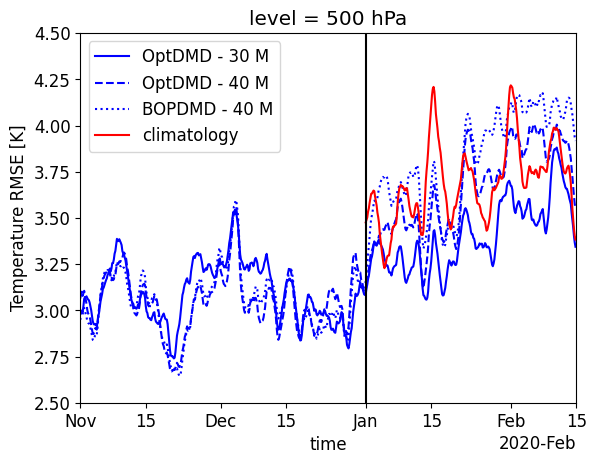

In [49]:
plt.rcParams.update({'font.size': 12})
rmse_optdmd_30 = xr.concat([rmse_recon_optdmd_30, rmse_forecast_optdmd_30], dim="time")
rmse_optdmd_40 = xr.concat([rmse_recon_optdmd_40, rmse_forecast_optdmd_40], dim="time")
rmse_bopdmd_40 = xr.concat([rmse_recon_bopdmd_40, rmse_forecast_bopdmd_40], dim="time")
rmse_optdmd_30.plot(label="OptDMD - 30 M", color="blue", linestyle="-")
rmse_optdmd_40.plot(label="OptDMD - 40 M", color="blue", linestyle="--")
rmse_bopdmd_40.plot(label="BOPDMD - 40 M", color="blue", linestyle=":")
rmse_climatology.plot(label="climatology", color="red")
plt.xlim([np.datetime64("2019-11-01T00:00"), np.datetime64("2020-02-15T00:00")])
plt.ylim([2.5, 4.5])
plt.ylabel("Temperature RMSE [K]")
plt.axvline(x=np.datetime64("2020-01-01T00:00"), color="black")
plt.legend()
plt.title("level = 500 hPa")
plt.show()

The graph clearly shows that the OptDMD model with 30 modes has the best forecasting performance, beating climatology for the whole forecast period. The 40 mode models show worse forecasting performance, although they show slightly better reconstruction accuracy. This indicates that the 40-mode models are likely overfitting the training data, while the sparse 30-mode model generalizes better to unseen data. Interestingly, bagging does not seem to help here - the reconstruction accuracy is very similar whether bagging is used or not, and it seems to hurt the forecasting performance. This is very likely due to inconsistent dynamics found across the randomly sampled bags, but would require further investigation as to why this is happening. 

Above, we computed the RMSE for the 40-mode BOPDMD model deterministically using the mean reconstruction/forecast. However, because the BOPDMD prediction is stochastic/probabilistic, we can incorporate the prediction uncertainty/variance in the calculation of an expected RMSE. The expected RMSE tells us the expected error of a random draw from our prediction distribution.

In [ ]:
rmse_recon_bopdmd_40_expected = compute_rmse(
    ground_truth.sel(time=slice("2019-11", "2019-12")),
    recon_bopdmd_40,
    recon_bopdmd_40_var,  # note now we pass the reconstruction variance
)

In [ ]:
rmse_forecast_bopdmd_40_expected = compute_rmse(
    ground_truth.sel(time=forecast_bopdmd_40.time),
    forecast_bopdmd_40,
    forecast_bopdmd_40_var,  # note now we pass the reconstruction variance
)

We can now compare the expected RMSE to the RMSE of the mean forecast, which gives an idea of how uncertainty in the forecast inflates the bias in the mean forecast.

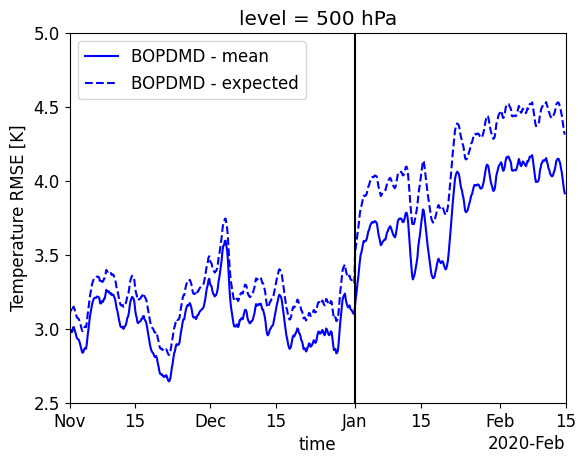

In [63]:
plt.rcParams.update({'font.size': 12})
rmse_bopdmd_40 = xr.concat([rmse_recon_bopdmd_40, rmse_forecast_bopdmd_40], dim="time")
rmse_bopdmd_40_expected = xr.concat(
    [rmse_recon_bopdmd_40_expected, rmse_forecast_bopdmd_40_expected], dim="time"
)
rmse_bopdmd_40.plot(label="BOPDMD - mean", color="blue", linestyle="-")
rmse_bopdmd_40_expected.plot(label="BOPDMD - expected", color="blue", linestyle="--")

plt.xlim([np.datetime64("2019-11-01T00:00"), np.datetime64("2020-02-15T00:00")])
plt.ylim([2.5, 5])
plt.ylabel("Temperature RMSE [K]")
plt.axvline(x=np.datetime64("2020-01-01T00:00"), color="black")
plt.legend()
plt.title("level = 500 hPa")
plt.show()

### 4.4 Compute the temporally-averaged reconstruction and forecast RMSE

Given the evaluation performed above showed that the 30-mode OptDMD model has the best forecasting performance, in this section we will compute the spatially-resolved, time-averaged RMSE for this model to identify the spatial locations with the highest reconstruction and forecast errors.

First compute the time-average RMSE for the reconstruction.

In [100]:
rmse_recon_optdmd_30 = compute_rmse(
    truth=ground_truth.sel(time=slice("2019-11", "2019-12")),
    prediction=recon_optdmd_30,
    lat_weighting=False,  # note here we don't want to apply spatial weighting
    dim="time",
)

In [101]:
rmse_recon_optdmd_30.name = "Temperature RMSE [K]"

Then compute it for the forecast.

In [102]:
rmse_forecast_optdmd_30 = compute_rmse(
    truth=ground_truth.sel(time=forecast_optdmd_30.time),
    prediction=forecast_optdmd_30,
    lat_weighting=False,  # note here we don't want to apply spatial weighting
    dim="time",
)

In [103]:
rmse_forecast_optdmd_30.name = "Temperature RMSE [K]"

Finally, compute it for climatology.

In [ ]:
rmse_climatology = compute_rmse(
    truth=ground_truth.sel(time=forecast_optdmd_30.time),
    prediction=climatology.sel(time=forecast_optdmd_30.time),
    lat_weighting=False,  # note here we don't want to apply spatial weighting
    dim="time",
)

In [130]:
rmse_climatology.name = "Temperature RMSE[K]"

The code below plots the time-averaged RMSE on a lat/lon grid.

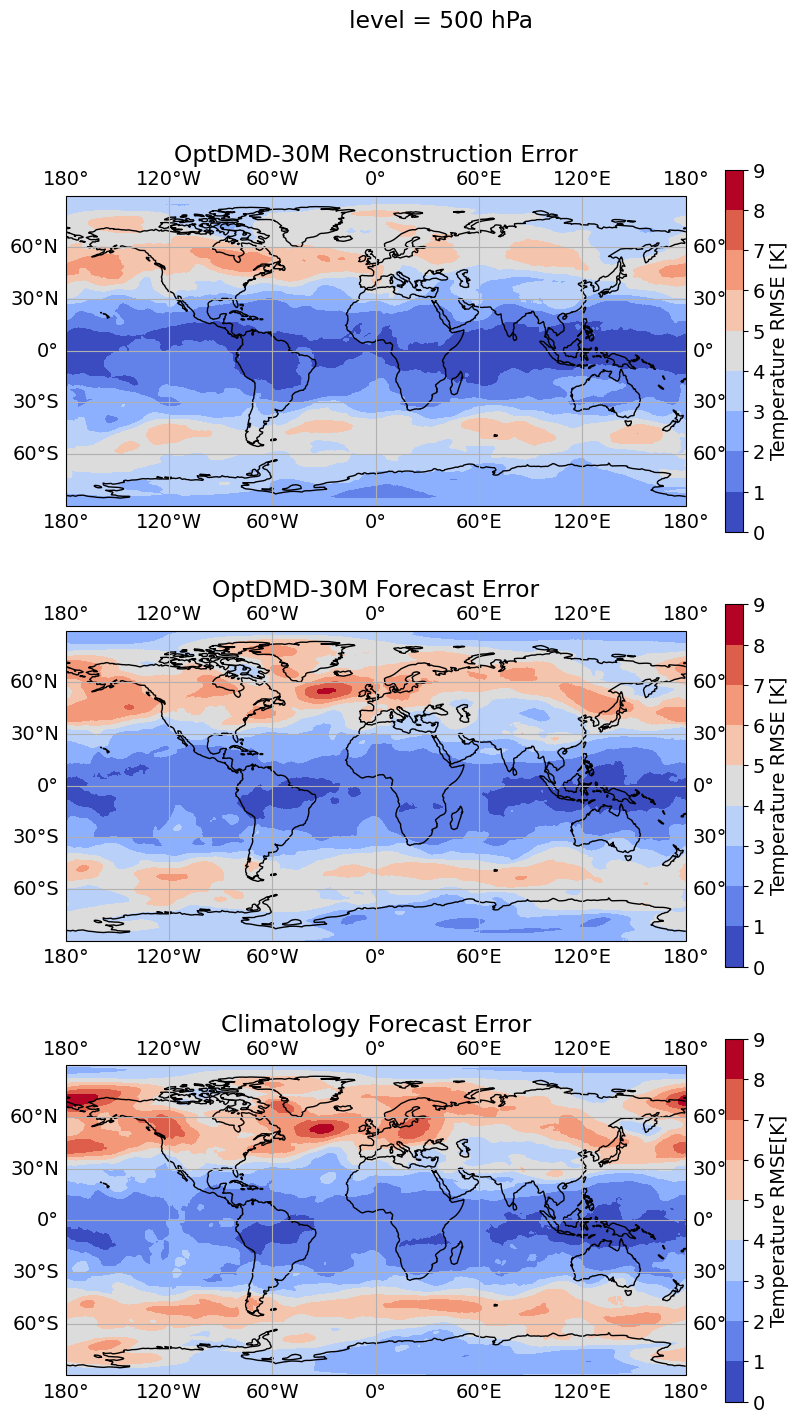

In [129]:
fig, axs = plt.subplots(
    3, 1, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree()}
)

ax = axs[0]
rmse_recon_optdmd_30.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(0, 10, 1)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("OptDMD-30M Reconstruction Error")

ax = axs[1]
rmse_forecast_optdmd_30.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(0, 10, 1)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("OptDMD-30M Forecast Error")

ax = axs[2]
rmse_climatology.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(0, 10, 1)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("Climatology Forecast Error")

fig.suptitle("level = 500 hPa")
plt.show()

The plots above show that OptDMD finds it hardest to reconstruct and forecast at latitudes ~50 deg N/S. This is likely because these are regions of localized, high dynamic variability. Not surprisingly, this is also where climatology struggles the most.  

## Conclusion

This notebook has shown how to use the `OptDMD` class of the SVDROM package to compute Optimized and Bagging Optimized Dynamic Mode Decomposition on a 35 GB slice of the ERA5 dataset directly on a laptop. As highlighted, this can be done very easily and quickly (in a matter of minutes), and a well calibrated DMD model can beat a naive climatological forecast.